## Data load and preprocess

In [42]:
# !usr/env/python in .env
from load_data import Download_Video
from datetime import datetime
import os
import logging
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load data
video_num = 10000 # originally, 10000 urls
frame_count = 10
video_time = 10
d = Download_Video(video_num, frame_count, video_time)
tic = datetime.now()
d.download_organizer()
toc = datetime.now()
print('Download time {0}'.format(toc-tic))

In [44]:
# process data
video_num = 10000
frame_count = 10
video_time = 10
d = Download_Video(video_num, frame_count, video_time)
tic = datetime.now()
d.preprocess_organizer()
toc = datetime.now()
print('Process time {0}'.format(toc-tic))

In [45]:
# data check
curr = os.getcwd() + '/datasets/category.npy'
y = np.load(curr)
print('Total number of videos: {0}'.format(y.shape[0]))
if y.shape[0] < video_num:
    print ('There exists invalid video url!')

Total number of videos: 8633
There exists invalid video url!


Average Video Count: 431.65


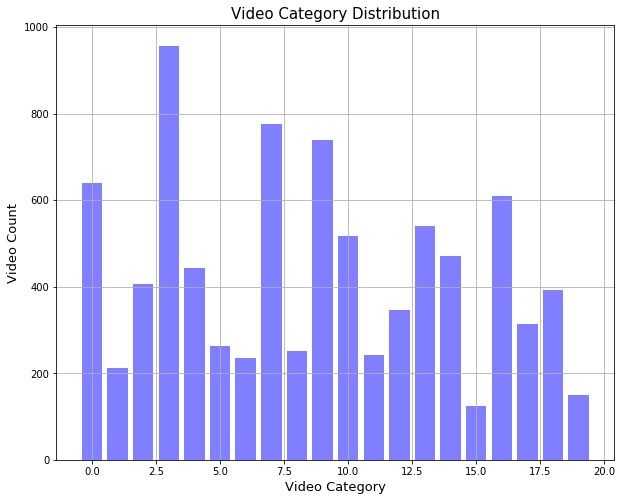

In [43]:
# classes balance check
categories = y[:, 1]
video_dic = Counter(categories)
video_dic = {int(key): value for key, value in video_dic.items()}
cat = list(video_dic.keys())
cat_count = list(video_dic.values())
print('Average Video Count: {0}'.format(sum(cat_count) / float(len(cat_count))))

# plotting
plt.bar(cat, cat_count, align='center',color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Video Category', fontsize = 13)
plt.ylabel('Video Count', fontsize = 13)
plt.title('Video Category Distribution', fontsize = 15)

In [ ]:
# balance data

## Video classification model

### pretrained vgg16 and 3D temporal max pooling

In [12]:
# !usr/env python 3.5 in .env
from pretrained_model import video_classification
from datetime import datetime
import os
import h5py
import sys
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# model
model = video_classification()
curr_path = os.getcwd()
frame_dir = curr_path + '/datasets/frames'

# set test video num
num_videos = 1000

# fuse features
tic = datetime.now()
features = model.load_features(frame_dir, num_videos)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)


  0%|          | 0/1000 [00:00<?, ?it/s]

Fuse video 0/1000









  0%|          | 1/1000 [00:00<04:46,  3.48it/s]



Fuse video 1/1000









  0%|          | 2/1000 [00:00<04:45,  3.50it/s]



Fuse video 2/1000









  0%|          | 3/1000 [00:00<04:41,  3.54it/s]



Fuse video 3/1000









  0%|          | 4/1000 [00:01<04:40,  3.55it/s]



Fuse video 4/1000









  0%|          | 5/1000 [00:01<04:45,  3.48it/s]



Fuse video 5/1000









  1%|          | 6/1000 [00:01<04:43,  3.51it/s]



Fuse video 6/1000









  1%|          | 7/1000 [00:02<04:53,  3.38it/s]



Fuse video 7/1000









  1%|          | 8/1000 [00:02<04:48,  3.43it/s]



Fuse video 8/1000









  1%|          | 9/1000 [00:02<04:54,  3.37it/s]



Fuse video 9/1000









  1%|          | 10/1000 [00:02<04:50,  3.40it/s]



Fuse video 10/1000









  1%|          | 11/1000 [00:03<04:43,  3.49it/s]



Fuse video 11/1000









  1%|          | 12/1000 [00:03<04:45,  3.46it/s]



Fuse video 12/1000









  1%|▏         | 13/1000 [00:03<04:48,  3.43it/s]



Fuse video 13/1000









  1%|▏         | 14/1000 [00:04<04:45,  3.45it/s]



Fuse video 14/1000


  2%|▏         | 15/1000 [00:04<04:42,  3.48it/s]

Fuse video 15/1000


  2%|▏         | 16/1000 [00:04<04:36,  3.56it/s]

Fuse video 16/1000


  2%|▏         | 17/1000 [00:04<04:33,  3.59it/s]

Fuse video 17/1000


  2%|▏         | 18/1000 [00:05<04:25,  3.70it/s]

Fuse video 18/1000


  2%|▏         | 19/1000 [00:05<04:26,  3.68it/s]

Fuse video 19/1000


  2%|▏         | 20/1000 [00:05<04:23,  3.72it/s]

Fuse video 20/1000


  2%|▏         | 21/1000 [00:05<04:21,  3.74it/s]

Fuse video 21/1000


  2%|▏         | 22/1000 [00:06<04:18,  3.79it/s]

Fuse video 22/1000


  2%|▏         | 23/1000 [00:06<04:20,  3.75it/s]

Fuse video 23/1000


  2%|▏         | 24/1000 [00:06<04:19,  3.76it/s]

Fuse video 24/1000


  2%|▎         | 25/1000 [00:06<04:17,  3.79it/s]

Fuse video 25/1000


  3%|▎         | 26/1000 [00:07<04:15,  3.81it/s]

Fuse video 26/1000


  3%|▎         | 27/1000 [00:07<04:18,  3.77it/s]

Fuse video 27/1000


  3%|▎         | 28/1000 [00:07<04:21,  3.71it/s]

Fuse video 28/1000


  3%|▎         | 29/1000 [00:08<04:22,  3.70it/s]

Fuse video 29/1000


  3%|▎         | 30/1000 [00:08<04:21,  3.72it/s]

Fuse video 30/1000


  3%|▎         | 31/1000 [00:08<04:18,  3.74it/s]

Fuse video 31/1000


  3%|▎         | 32/1000 [00:08<04:18,  3.75it/s]

Fuse video 32/1000


  3%|▎         | 33/1000 [00:09<04:20,  3.71it/s]

Fuse video 33/1000


  3%|▎         | 34/1000 [00:09<04:22,  3.68it/s]

Fuse video 34/1000


  4%|▎         | 35/1000 [00:09<04:24,  3.66it/s]

Fuse video 35/1000


  4%|▎         | 36/1000 [00:09<04:18,  3.73it/s]

Fuse video 36/1000


  4%|▎         | 37/1000 [00:10<04:19,  3.71it/s]

Fuse video 37/1000


  4%|▍         | 38/1000 [00:10<04:21,  3.68it/s]

Fuse video 38/1000


  4%|▍         | 39/1000 [00:10<04:24,  3.63it/s]

Fuse video 39/1000


  4%|▍         | 40/1000 [00:11<04:24,  3.63it/s]

Fuse video 40/1000


  4%|▍         | 41/1000 [00:11<04:22,  3.65it/s]

Fuse video 41/1000


  4%|▍         | 42/1000 [00:11<04:22,  3.65it/s]

Fuse video 42/1000


  4%|▍         | 43/1000 [00:11<04:22,  3.65it/s]

Fuse video 43/1000


  4%|▍         | 44/1000 [00:12<04:20,  3.67it/s]

Fuse video 44/1000


  4%|▍         | 45/1000 [00:12<04:22,  3.64it/s]

Fuse video 45/1000


  5%|▍         | 46/1000 [00:12<04:20,  3.66it/s]

Fuse video 46/1000


  5%|▍         | 47/1000 [00:12<04:18,  3.69it/s]

Fuse video 47/1000


  5%|▍         | 48/1000 [00:13<04:20,  3.66it/s]

Fuse video 48/1000


  5%|▍         | 49/1000 [00:13<04:19,  3.66it/s]

Fuse video 49/1000


  5%|▌         | 50/1000 [00:13<04:20,  3.64it/s]

Fuse video 50/1000


  5%|▌         | 51/1000 [00:14<04:14,  3.73it/s]

Fuse video 51/1000


  5%|▌         | 52/1000 [00:14<04:16,  3.70it/s]

Fuse video 52/1000


  5%|▌         | 53/1000 [00:14<04:18,  3.66it/s]

Fuse video 53/1000


  5%|▌         | 54/1000 [00:14<04:19,  3.65it/s]

Fuse video 54/1000


  6%|▌         | 55/1000 [00:15<04:14,  3.72it/s]

Fuse video 55/1000


  6%|▌         | 56/1000 [00:15<04:13,  3.72it/s]

Fuse video 56/1000


  6%|▌         | 57/1000 [00:15<04:09,  3.77it/s]

Fuse video 57/1000


  6%|▌         | 58/1000 [00:15<04:09,  3.77it/s]

Fuse video 58/1000


  6%|▌         | 59/1000 [00:16<04:09,  3.77it/s]

Fuse video 59/1000


  6%|▌         | 60/1000 [00:16<04:06,  3.81it/s]

Fuse video 60/1000


  6%|▌         | 61/1000 [00:16<04:09,  3.76it/s]

Fuse video 61/1000


  6%|▌         | 62/1000 [00:16<04:08,  3.78it/s]

Fuse video 62/1000


  6%|▋         | 63/1000 [00:17<04:10,  3.73it/s]

Fuse video 63/1000


  6%|▋         | 64/1000 [00:17<04:11,  3.72it/s]

Fuse video 64/1000


  6%|▋         | 65/1000 [00:17<04:08,  3.77it/s]

Fuse video 65/1000


  7%|▋         | 66/1000 [00:18<04:08,  3.76it/s]

Fuse video 66/1000


  7%|▋         | 67/1000 [00:18<04:06,  3.79it/s]

Fuse video 67/1000


  7%|▋         | 68/1000 [00:18<04:03,  3.83it/s]

Fuse video 68/1000


  7%|▋         | 69/1000 [00:18<04:03,  3.83it/s]

Fuse video 69/1000


  7%|▋         | 70/1000 [00:19<04:04,  3.80it/s]

Fuse video 70/1000


  7%|▋         | 71/1000 [00:19<04:05,  3.79it/s]

Fuse video 71/1000


  7%|▋         | 72/1000 [00:19<04:02,  3.82it/s]

Fuse video 72/1000


  7%|▋         | 73/1000 [00:19<04:05,  3.78it/s]

Fuse video 73/1000


  7%|▋         | 74/1000 [00:20<04:02,  3.82it/s]

Fuse video 74/1000


  8%|▊         | 75/1000 [00:20<03:59,  3.86it/s]

Fuse video 75/1000


  8%|▊         | 76/1000 [00:20<03:57,  3.89it/s]

Fuse video 76/1000


  8%|▊         | 77/1000 [00:20<04:01,  3.83it/s]

Fuse video 77/1000


  8%|▊         | 78/1000 [00:21<04:01,  3.82it/s]

Fuse video 78/1000


  8%|▊         | 79/1000 [00:21<04:02,  3.80it/s]

Fuse video 79/1000


  8%|▊         | 80/1000 [00:21<04:00,  3.83it/s]

Fuse video 80/1000


  8%|▊         | 81/1000 [00:21<03:59,  3.84it/s]

Fuse video 81/1000


  8%|▊         | 82/1000 [00:22<03:55,  3.90it/s]

Fuse video 82/1000


  8%|▊         | 83/1000 [00:22<03:55,  3.90it/s]

Fuse video 83/1000


  8%|▊         | 84/1000 [00:22<03:56,  3.88it/s]

Fuse video 84/1000


  8%|▊         | 85/1000 [00:22<04:00,  3.81it/s]

Fuse video 85/1000


  9%|▊         | 86/1000 [00:23<03:56,  3.86it/s]

Fuse video 86/1000


  9%|▊         | 87/1000 [00:23<04:02,  3.76it/s]

Fuse video 87/1000


  9%|▉         | 88/1000 [00:23<04:06,  3.69it/s]

Fuse video 88/1000


  9%|▉         | 89/1000 [00:24<04:03,  3.73it/s]

Fuse video 89/1000


  9%|▉         | 90/1000 [00:24<04:01,  3.78it/s]

Fuse video 90/1000


  9%|▉         | 91/1000 [00:24<03:58,  3.81it/s]

Fuse video 91/1000


  9%|▉         | 92/1000 [00:24<04:03,  3.73it/s]

Fuse video 92/1000


  9%|▉         | 93/1000 [00:25<04:00,  3.77it/s]

Fuse video 93/1000


  9%|▉         | 94/1000 [00:25<04:05,  3.69it/s]

Fuse video 94/1000


 10%|▉         | 95/1000 [00:25<04:01,  3.75it/s]

Fuse video 95/1000


 10%|▉         | 96/1000 [00:25<04:01,  3.74it/s]

Fuse video 96/1000


 10%|▉         | 97/1000 [00:26<04:04,  3.69it/s]

Fuse video 97/1000


 10%|▉         | 98/1000 [00:26<04:06,  3.66it/s]

Fuse video 98/1000


 10%|▉         | 99/1000 [00:26<04:03,  3.70it/s]

Fuse video 99/1000


 10%|█         | 100/1000 [00:27<03:59,  3.75it/s]

Fuse video 100/1000


 10%|█         | 101/1000 [00:27<03:59,  3.75it/s]

Fuse video 101/1000


 10%|█         | 102/1000 [00:27<04:01,  3.72it/s]

Fuse video 102/1000


 10%|█         | 103/1000 [00:27<03:57,  3.78it/s]

Fuse video 103/1000


 10%|█         | 104/1000 [00:28<04:00,  3.73it/s]

Fuse video 104/1000


 10%|█         | 105/1000 [00:28<04:01,  3.71it/s]

Fuse video 105/1000


 11%|█         | 106/1000 [00:28<03:58,  3.74it/s]

Fuse video 106/1000


 11%|█         | 107/1000 [00:28<04:00,  3.71it/s]

Fuse video 107/1000


 11%|█         | 108/1000 [00:29<04:01,  3.69it/s]

Fuse video 108/1000


 11%|█         | 109/1000 [00:29<04:02,  3.67it/s]

Fuse video 109/1000


 11%|█         | 110/1000 [00:29<03:59,  3.72it/s]

Fuse video 110/1000


 11%|█         | 111/1000 [00:29<03:57,  3.75it/s]

Fuse video 111/1000


 11%|█         | 112/1000 [00:30<03:55,  3.77it/s]

Fuse video 112/1000


 11%|█▏        | 113/1000 [00:30<03:54,  3.79it/s]

Fuse video 113/1000


 11%|█▏        | 114/1000 [00:30<03:51,  3.83it/s]

Fuse video 114/1000


 12%|█▏        | 115/1000 [00:30<03:50,  3.84it/s]

Fuse video 115/1000


 12%|█▏        | 116/1000 [00:31<03:50,  3.83it/s]

Fuse video 116/1000


 12%|█▏        | 117/1000 [00:31<03:47,  3.88it/s]

Fuse video 117/1000


 12%|█▏        | 118/1000 [00:31<03:48,  3.87it/s]

Fuse video 118/1000


 12%|█▏        | 119/1000 [00:32<03:48,  3.86it/s]

Fuse video 119/1000


 12%|█▏        | 120/1000 [00:32<03:48,  3.86it/s]

Fuse video 120/1000


 12%|█▏        | 121/1000 [00:32<03:48,  3.85it/s]

Fuse video 121/1000


 12%|█▏        | 122/1000 [00:32<03:46,  3.87it/s]

Fuse video 122/1000


 12%|█▏        | 123/1000 [00:33<03:46,  3.88it/s]

Fuse video 123/1000


 12%|█▏        | 124/1000 [00:33<03:46,  3.87it/s]

Fuse video 124/1000


 12%|█▎        | 125/1000 [00:33<03:48,  3.83it/s]

Fuse video 125/1000


 13%|█▎        | 126/1000 [00:33<03:51,  3.78it/s]

Fuse video 126/1000


 13%|█▎        | 127/1000 [00:34<03:52,  3.75it/s]

Fuse video 127/1000


 13%|█▎        | 128/1000 [00:34<03:50,  3.78it/s]

Fuse video 128/1000


 13%|█▎        | 129/1000 [00:34<03:51,  3.76it/s]

Fuse video 129/1000


 13%|█▎        | 130/1000 [00:34<03:52,  3.74it/s]

Fuse video 130/1000


 13%|█▎        | 131/1000 [00:35<03:54,  3.71it/s]

Fuse video 131/1000


 13%|█▎        | 132/1000 [00:35<03:53,  3.71it/s]

Fuse video 132/1000


 13%|█▎        | 133/1000 [00:35<03:53,  3.72it/s]

Fuse video 133/1000


 13%|█▎        | 134/1000 [00:36<03:53,  3.71it/s]

Fuse video 134/1000


 14%|█▎        | 135/1000 [00:36<03:51,  3.74it/s]

Fuse video 135/1000


 14%|█▎        | 136/1000 [00:36<03:52,  3.72it/s]

Fuse video 136/1000


 14%|█▎        | 137/1000 [00:36<03:52,  3.72it/s]

Fuse video 137/1000


 14%|█▍        | 138/1000 [00:37<03:53,  3.69it/s]

Fuse video 138/1000


 14%|█▍        | 139/1000 [00:37<03:51,  3.72it/s]

Fuse video 139/1000


 14%|█▍        | 140/1000 [00:37<03:51,  3.72it/s]

Fuse video 140/1000


 14%|█▍        | 141/1000 [00:37<03:49,  3.74it/s]

Fuse video 141/1000


 14%|█▍        | 142/1000 [00:38<03:45,  3.80it/s]

Fuse video 142/1000


 14%|█▍        | 143/1000 [00:38<03:45,  3.81it/s]

Fuse video 143/1000


 14%|█▍        | 144/1000 [00:38<03:49,  3.74it/s]

Fuse video 144/1000


 14%|█▍        | 145/1000 [00:38<03:52,  3.68it/s]

Fuse video 145/1000


 15%|█▍        | 146/1000 [00:39<03:50,  3.70it/s]

Fuse video 146/1000


 15%|█▍        | 147/1000 [00:39<03:47,  3.75it/s]

Fuse video 147/1000


 15%|█▍        | 148/1000 [00:39<03:53,  3.65it/s]

Fuse video 148/1000


 15%|█▍        | 149/1000 [00:40<03:54,  3.63it/s]

Fuse video 149/1000


 15%|█▌        | 150/1000 [00:40<03:55,  3.60it/s]

Fuse video 150/1000


 15%|█▌        | 151/1000 [00:40<03:52,  3.66it/s]

Fuse video 151/1000


 15%|█▌        | 152/1000 [00:40<03:51,  3.66it/s]

Fuse video 152/1000


 15%|█▌        | 153/1000 [00:41<03:51,  3.66it/s]

Fuse video 153/1000


 15%|█▌        | 154/1000 [00:41<03:53,  3.62it/s]

Fuse video 154/1000


 16%|█▌        | 155/1000 [00:41<03:52,  3.64it/s]

Fuse video 155/1000


 16%|█▌        | 156/1000 [00:41<03:51,  3.64it/s]

Fuse video 156/1000


 16%|█▌        | 157/1000 [00:42<03:53,  3.62it/s]

Fuse video 157/1000


 16%|█▌        | 158/1000 [00:42<03:53,  3.61it/s]

Fuse video 158/1000


 16%|█▌        | 159/1000 [00:42<03:58,  3.53it/s]

Fuse video 159/1000


 16%|█▌        | 160/1000 [00:43<03:55,  3.57it/s]

Fuse video 160/1000


 16%|█▌        | 161/1000 [00:43<03:53,  3.59it/s]

Fuse video 161/1000


 16%|█▌        | 162/1000 [00:43<03:50,  3.63it/s]

Fuse video 162/1000


 16%|█▋        | 163/1000 [00:43<03:51,  3.62it/s]

Fuse video 163/1000


 16%|█▋        | 164/1000 [00:44<03:49,  3.64it/s]

Fuse video 164/1000


 16%|█▋        | 165/1000 [00:44<03:50,  3.63it/s]

Fuse video 165/1000


 17%|█▋        | 166/1000 [00:44<03:50,  3.62it/s]

Fuse video 166/1000


 17%|█▋        | 167/1000 [00:45<03:47,  3.66it/s]

Fuse video 167/1000


 17%|█▋        | 168/1000 [00:45<03:46,  3.67it/s]

Fuse video 168/1000


 17%|█▋        | 169/1000 [00:45<03:47,  3.65it/s]

Fuse video 169/1000


 17%|█▋        | 170/1000 [00:45<03:49,  3.62it/s]

Fuse video 170/1000


 17%|█▋        | 171/1000 [00:46<03:48,  3.64it/s]

Fuse video 171/1000


 17%|█▋        | 172/1000 [00:46<03:47,  3.63it/s]

Fuse video 172/1000


 17%|█▋        | 173/1000 [00:46<03:45,  3.66it/s]

Fuse video 173/1000


 17%|█▋        | 174/1000 [00:46<03:47,  3.63it/s]

Fuse video 174/1000


 18%|█▊        | 175/1000 [00:47<03:47,  3.63it/s]

Fuse video 175/1000


 18%|█▊        | 176/1000 [00:47<03:47,  3.62it/s]

Fuse video 176/1000


 18%|█▊        | 177/1000 [00:47<03:46,  3.64it/s]

Fuse video 177/1000


 18%|█▊        | 178/1000 [00:48<03:46,  3.63it/s]

Fuse video 178/1000


 18%|█▊        | 179/1000 [00:48<03:43,  3.67it/s]

Fuse video 179/1000


 18%|█▊        | 180/1000 [00:48<03:46,  3.62it/s]

Fuse video 180/1000


 18%|█▊        | 181/1000 [00:48<03:48,  3.58it/s]

Fuse video 181/1000


 18%|█▊        | 182/1000 [00:49<03:42,  3.68it/s]

Fuse video 182/1000


 18%|█▊        | 183/1000 [00:49<03:39,  3.71it/s]

Fuse video 183/1000


 18%|█▊        | 184/1000 [00:49<03:40,  3.70it/s]

Fuse video 184/1000


 18%|█▊        | 185/1000 [00:49<03:36,  3.76it/s]

Fuse video 185/1000


 19%|█▊        | 186/1000 [00:50<03:39,  3.72it/s]

Fuse video 186/1000


 19%|█▊        | 187/1000 [00:50<03:40,  3.68it/s]

Fuse video 187/1000


 19%|█▉        | 188/1000 [00:50<03:41,  3.66it/s]

Fuse video 188/1000


 19%|█▉        | 189/1000 [00:51<03:38,  3.72it/s]

Fuse video 189/1000


 19%|█▉        | 190/1000 [00:51<03:35,  3.75it/s]

Fuse video 190/1000


 19%|█▉        | 191/1000 [00:51<03:38,  3.70it/s]

Fuse video 191/1000


 19%|█▉        | 192/1000 [00:51<03:40,  3.67it/s]

Fuse video 192/1000


 19%|█▉        | 193/1000 [00:52<03:41,  3.64it/s]

Fuse video 193/1000


 19%|█▉        | 194/1000 [00:52<03:40,  3.65it/s]

Fuse video 194/1000


 20%|█▉        | 195/1000 [00:52<03:40,  3.65it/s]

Fuse video 195/1000


 20%|█▉        | 196/1000 [00:52<03:41,  3.63it/s]

Fuse video 196/1000


 20%|█▉        | 197/1000 [00:53<03:40,  3.64it/s]

Fuse video 197/1000


 20%|█▉        | 198/1000 [00:53<03:39,  3.65it/s]

Fuse video 198/1000


 20%|█▉        | 199/1000 [00:53<03:42,  3.60it/s]

Fuse video 199/1000


 20%|██        | 200/1000 [00:54<03:38,  3.66it/s]

Fuse video 200/1000


 20%|██        | 201/1000 [00:54<03:38,  3.66it/s]

Fuse video 201/1000


 20%|██        | 202/1000 [00:54<03:37,  3.67it/s]

Fuse video 202/1000


 20%|██        | 203/1000 [00:54<03:32,  3.74it/s]

Fuse video 203/1000


 20%|██        | 204/1000 [00:55<03:33,  3.73it/s]

Fuse video 204/1000


 20%|██        | 205/1000 [00:55<03:36,  3.68it/s]

Fuse video 205/1000


 21%|██        | 206/1000 [00:55<03:34,  3.70it/s]

Fuse video 206/1000


 21%|██        | 207/1000 [00:55<03:32,  3.74it/s]

Fuse video 207/1000


 21%|██        | 208/1000 [00:56<03:30,  3.77it/s]

Fuse video 208/1000


 21%|██        | 209/1000 [00:56<03:28,  3.79it/s]

Fuse video 209/1000


 21%|██        | 210/1000 [00:56<03:31,  3.73it/s]

Fuse video 210/1000


 21%|██        | 211/1000 [00:57<03:33,  3.70it/s]

Fuse video 211/1000


 21%|██        | 212/1000 [00:57<03:30,  3.75it/s]

Fuse video 212/1000


 21%|██▏       | 213/1000 [00:57<03:29,  3.76it/s]

Fuse video 213/1000


 21%|██▏       | 214/1000 [00:57<03:29,  3.75it/s]

Fuse video 214/1000


 22%|██▏       | 215/1000 [00:58<03:28,  3.77it/s]

Fuse video 215/1000


 22%|██▏       | 216/1000 [00:58<03:30,  3.73it/s]

Fuse video 216/1000


 22%|██▏       | 217/1000 [00:58<03:28,  3.76it/s]

Fuse video 217/1000


 22%|██▏       | 218/1000 [00:58<03:29,  3.74it/s]

Fuse video 218/1000


Process ForkPoolWorker-4823:
Process ForkPoolWorker-4809:
Process ForkPoolWorker-4818:
Process ForkPoolWorker-4816:
Process ForkPoolWorker-4822:
Process ForkPoolWorker-4819:
Process ForkPoolWorker-4811:
Process ForkPoolWorker-4821:
Process ForkPoolWorker-4813:
Process ForkPoolWorker-4815:
Process ForkPoolWorker-4810:
Process ForkPoolWorker-4814:
Process ForkPoolWorker-4812:
Process ForkPoolWorker-4817:
Process ForkPoolWorker-4820:
Process ForkPoolWorker-6569:
Process ForkPoolWorker-6568:
Process ForkPoolWorker-6572:
Process ForkPoolWorker-4808:
Process ForkPoolWorker-6571:
Process ForkPoolWorker-6573:
Process ForkPoolWorker-6570:















Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last

KeyboardInterrupt: 

In [6]:
# load true labels
curr_path = os.getcwd()
y = np.load(curr_path+'/datasets/category.npy')
num_video = len(y)
print('Total number of video: {0}'.format(num_video))

Total number of video: 8633


In [ ]:
# train model
hist = model.train(features, y, lr = 1e-3)

Model is Training...
dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


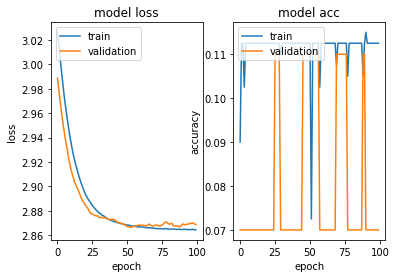

In [24]:
# summarize history for accuracy

In [25]:
model.predict(features, y)

Video Classification Accuracy: 0.104


### Direct 3D Convolutional 

In [ ]:
from frame_classification_process import frame_process
import numpy as np
import os

curr_path = os.getcwd()
x_train_ind = np.load(curr_path+'/datasets/x_train_ind_above400.npy')
y_train = np.load(curr_path+'/datasets/y_train_mapped_above400.npy')
num_videos = len(y_train)
fp = frame_process(num_videos, size = (80,80,3))
X = fp.process_updates_frameSeq_stacked(x_train_ind, y_train, 10)



## model Test in random data points

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


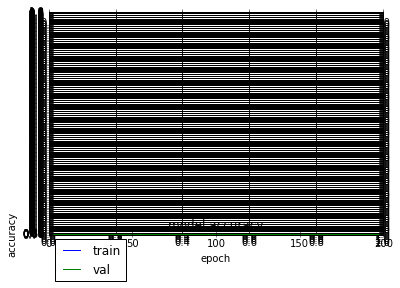

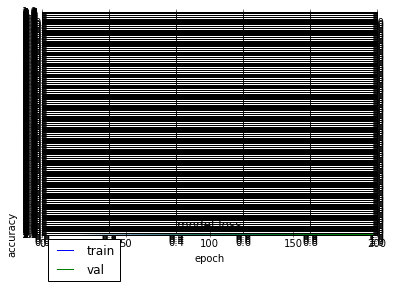

In [13]:
# test model train example

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import keras
from keras import regularizers
%matplotlib inline

num_classes = 5
m = Sequential()
m.add(Dense(32, activation='relu', input_dim=100, kernel_regularizer=regularizers.l2(0.01), 
            activity_regularizer=regularizers.l1(0.01)))

m.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
sgd_m = keras.optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True)
m.compile(optimizer=sgd_m,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
d1 = 5000
d2 = int(d1 * 0.8)
data = np.random.random((d1, 100))
labels = np.random.randint(num_classes, size=(d1, 1))
yte = labels[d2:]
labels = to_categorical(labels, num_classes = num_classes)
ytr = labels[:d2]
Xtr = data[:d2]
Xte = data[d2:]


# Train the model, iterating on the data in batches of 32 samples
history = m.fit(Xtr, ytr, epochs=200, batch_size=50, validation_split = 0.2, verbose = 0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy

plt.subplots(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplots(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
# predict
ypred = m.predict(Xte)
ypred = np.argmax(ypred, axis = 1)
print('Test Accuracy: {0}'.format(np.mean(ypred == yte)))

Test Accuracy: 0.202555


## frame classification

In [12]:
from frame_classification import frame_classification
from frame_classification_process import frame_process
import matplotlib.pyplot as plt
import numpy as np
import os 

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
num_video = 8000
frame_idx = 1
fp = frame_process(num_video, frame_idx)

# raw process with num_video, frame_idx
# X = fp.process_original()

In [14]:
# load balanced datasets index
npy_path = os.getcwd() + '/datasets/'
Xtr_ind = np.load(npy_path + 'x_train_ind_above400.npy')
Xte_ind = np.load(npy_path + 'x_test_ind_above400.npy')
ytr = np.load(npy_path + 'y_train_mapped_above400.npy')
yte = np.load(npy_path + 'y_test_mapped_above400.npy')

assert len(Xtr_ind) == len(ytr)
assert len(Xte_ind) == len(yte)

print('Training sets size: {0}'.format(len(Xtr_ind)))
print('Test sets size: {0}'.format(len(Xte_ind)))
print('Xtrain index shape: ', Xtr_ind.shape)
print('ytrain shape: ', ytr.shape)
print('Xtest index shape: ', Xte_ind.shape)
print('ytest shape: ', yte.shape)

Training sets size: 4270
Test sets size: 1830
Xtrain index shape:  (4270,)
ytrain shape:  (4270,)
Xtest index shape:  (1830,)
ytest shape:  (1830,)


In [15]:
# load train and test from file folders
Xtr = fp.process_updated(Xtr_ind, ytr)
Xte = fp.process_updated(Xte_ind, yte)

100%|██████████| 1830/1830 [00:19<00:00, 94.39it/s]


In [16]:
print('Xtrain shape: ', Xtr.shape)
print('Xtest shape: ', Xte.shape)

Xtrain shape:  (4270, 224, 224, 3)
Xtest shape:  (1830, 224, 224, 3)


In [18]:
lr = 1e-2
num_classes = 10
reg = 0.01
fc = frame_classification(lr, num_classes, reg = reg)

# load true labels
curr = os.getcwd() + '/datasets/category.npy'
y = np.load(curr)[:num_video, 1]

# random labels trial
# y = np.random.randint(num_classes, size = (num_video, 1))

bsize = 32; epoch = 50; verbose = 1; split_ratio = 0.2
fc.train(Xtr, ytr, bsize, epoch, verbose, split_ratio)

Train on 3416 samples, validate on 854 samples
Epoch 1/50
3416/3416 [==============================] - 201s - loss: 2.4493 - acc: 0.1642 - val_loss: 2.4023 - val_acc: 0.1674
Epoch 2/50
3416/3416 [==============================] - 196s - loss: 2.3808 - acc: 0.1487 - val_loss: 2.3520 - val_acc: 0.1674
Epoch 3/50
3416/3416 [==============================] - 196s - loss: 2.3416 - acc: 0.1484 - val_loss: 2.3215 - val_acc: 0.1674
Epoch 4/50
 288/3416 [=>............................] - ETA: 167s - loss: 2.3212 - acc: 0.1424

KeyboardInterrupt: 

AttributeError: 'NoneType' object has no attribute 'history'

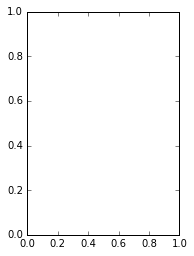

In [19]:
# plot loss and accuracy
fc.plot()

In [ ]:
# test accuracy
fc.predict(Xte, yte)